imports

In [ ]:
#empty lol

In [4]:

import copy

import numpy as np
from numpy import nan
import scipy as sp
import sklearn as sk
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


import pandas as pd
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)


import math as m # math stuff
import random as rd #always good to have
import matplotlib.pyplot as plt #plots.


import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import functools as ft

import itertools


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import os

import sys
if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO

np.random.seed(1234)
print("Import finished, \nhere's a random number:",rd.random(),"\nIf the number changed, the cell ran correctly. ")

Import finished, 
here's a random number: 0.5792825565359677 
If the number changed, the cell ran correctly. 


set directory

In [5]:
from google.colab import drive

drive.mount('/content/gdrive/')

os.chdir("/content/gdrive//MyDrive/comp551/A2/train") # change to your directory
print("The path is:", os.getcwd() )
print("All the files are: ",os.listdir())

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
The path is: /content/gdrive/MyDrive/comp551/A2/train
All the files are:  ['pos', 'neg', 'imdb.vocab', 'imdbEr.txt', 'neg.zip', 'pos.zip', 'labeledBow.feat', '__MACOSX', 'posTrain.csv', 'negTrain.csv', 'testInstances.csv', 'trainInstances.csv', 'trainReviewsVectorized.csv', 'imdbTestResponseVariables.csv', 'imdbTrainIDs_ResponseVariables.csv', 'imdbTestIDs_ResponseVariables.csv', 'imbdTestingVocab.csv', 'imbdTrainingVocab.csv', 'imdbTrainingData.csv', 'imdbTestingData.csv', 'FeatureImportance.png', 'PCA.png', 'featureHeatmap.png', 'trainingSetNewsGroups.csv', 'testingSetNewsGroups.csv', 'ce_iteration.png', 'roc_cIMDB.png', 'data.csv']


TASK 1.1 : IMBD DATASET

First, unzip the large pos and neg files.

In [ ]:
#!unzip /content/gdrive/MyDrive/comp551/A2/train/pos.zip
#!unzip /content/gdrive/MyDrive/comp551/A2/train/neg.zip

#!unzip /content/gdrive/MyDrive/comp551/A2/test/pos.zip
#!unzip /content/gdrive/MyDrive/comp551/A2/test/neg.zip


# this only needed to be done once. no need to run this portion again.
# within the train/test folder, we now have a folder with each pos review and a folder with each neg review which we will read later on

load vocab. turn text into tabular data.

In [ ]:

vocabFile = open('imdb.vocab','r+')
vocabData = vocabFile.read()
print(type(vocabData))

print(type(vocabFile))
print(type(vocabData))
vocab = vocabData.split("\n")
vocab = pd.DataFrame(vocab)
print(vocab.head()) #each row is one word


<class 'str'>
<class '_io.TextIOWrapper'>
<class 'str'>
     0
0  the
1  and
2    a
3   of
4   to


create a DF will training and testing info
each DF contains review id, review text, sentiment, and numerial rating

In [ ]:
## ran this once. it yielded 2 files called "TrainInstances" and "TestInstances" which we can load in the next chunk

trainInstances = {}
for sentiment in ['pos','neg']:
    for filename in os.listdir(f'/content/gdrive//MyDrive/comp551/A2/train/{sentiment}'):
      id_, rating = filename[:-4].split('_')
      with open(f'/content/gdrive//MyDrive/comp551/A2/train/{sentiment}/{filename}','r') as text:
        review = text.read()

      if sentiment == 'neg':
        id = 12_500 + int(id_)
      else:
        id = int(id_)

      trainInstances[id] = {"id":id, "review":review, "sentiment":sentiment, "rating":rating}

testInstances = {}
for sentiment in ['pos','neg']:
    for filename in os.listdir(f'/content/gdrive//MyDrive/comp551/A2/test/{sentiment}'):
      id_, rating = filename[:-4].split('_')
      with open(f'/content/gdrive//MyDrive/comp551/A2/test/{sentiment}/{filename}','r') as text:
        review = text.read()

      if sentiment == 'neg':
        id = 12_500 + int(id_)
      else:
        id = int(id_)

      testInstances[id] = {"id":id, "review":review, "sentiment":sentiment, "rating":rating}


#write csv to easy access later

df1 =  pd.DataFrame(trainInstances)
trainInstances = df1.transpose()
trainInstances.to_csv('trainInstances.csv', index=False)

df2 =  pd.DataFrame(testInstances)
testInstances = df2.transpose()
testInstances.to_csv('testInstances.csv', index=False)


Separate features from response variable

In [6]:
# load in pre-establisd csv of data
trainInstances = pd.read_csv("trainInstances.csv")
testInstances = pd.read_csv("testInstances.csv")

trainReviews = trainInstances.drop(['id','sentiment','rating'], axis = 1).astype('str')
testReviews = testInstances.drop(['id','sentiment','rating'], axis = 1).astype('str')

print(trainInstances.head())
print(trainReviews.head())

    id                                             review sentiment  rating
0   72  I just recently watched this 1954 movie starri...       pos       7
1  165  One of my favorite scenes is at the beginning ...       pos       7
2  779  In Northeastern of Brazil, the father of the t...       pos      10
3  704  This film, as low budget as it may be, is one ...       pos      10
4  723  Riff Randell is a wildly, obsessed fan of the ...       pos       8
                                              review
0  I just recently watched this 1954 movie starri...
1  One of my favorite scenes is at the beginning ...
2  In Northeastern of Brazil, the father of the t...
3  This film, as low budget as it may be, is one ...
4  Riff Randell is a wildly, obsessed fan of the ...


remove low and high frequency words using CountVectorizer

In [7]:

# GET WORD COUNTS

#train
vectorizer = CountVectorizer(stop_words='english',min_df = 0.01) #create vectorizer and drop common and low freq. words
counts = vectorizer.fit_transform(trainReviews.review) #fit vectorizer and transform training set
print(vectorizer.vocabulary_) #view vocab

xTrainDF = pd.DataFrame(counts.toarray())
xTrainDF.columns = vectorizer.get_feature_names_out()
print(xTrainDF.info()) #make sure it worked


#test
counts = vectorizer.transform(testReviews.review) #fit vectorizer using the same vectorizer as we did on training so variables match for model prediction

xTestDF = pd.DataFrame(counts.toarray())
xTestDF.columns = vectorizer.get_feature_names_out()
print(xTestDF.info()) #make sure it worked


{'just': 729, 'recently': 1086, 'watched': 1460, 'movie': 895, 'starring': 1260, 'time': 1359, 'classic': 238, 'movies': 896, 'don': 382, 'murder': 900, 'boss': 157, 'wife': 1475, 'portrayed': 1022, 'brief': 168, 'role': 1123, 'actually': 32, 'character': 214, 'mad': 824, 'people': 978, 'taking': 1322, 'br': 165, 'doesn': 379, 'horror': 662, 'famous': 489, 'roles': 1124, 'favorite': 501, 'house': 668, 'going': 591, 'viewers': 1435, 'fans': 491, 'scenes': 1152, 'beginning': 129, 'decide': 336, 'father': 498, 'years': 1515, 'old': 945, 'daughter': 328, 'middle': 869, 'man': 834, 'better': 137, 'life': 781, 'girl': 582, 'gives': 586, 'son': 1233, 'sexual': 1186, 'experience': 465, 'sent': 1175, 'field': 515, 'expecting': 464, 'sad': 1134, 'reality': 1079, 'child': 225, 'year': 1514, 'saw': 1143, 'tells': 1338, 'story': 1279, 'problem': 1041, 'does': 378, 'exist': 459, 'world': 1499, 'director': 367, 'writer': 1507, 'great': 603, 'showing': 1200, 'nudity': 933, 'promising': 1051, 'excellen

set training and test variables for linear regression

In [8]:
xTrain = xTrainDF #rename to make things simplier
xTest = xTestDF

trainInstances['sentiment'].replace({'neg': 0, 'pos': 1}, inplace=True) # recode response to numerical
testInstances['sentiment'].replace({'neg': 0, 'pos': 1}, inplace=True) # recode response to numerical

yTrain = trainInstances['sentiment'] #we want to predict only sentiment
yTest = testInstances['sentiment']


Implement linear regression for feature importance

In [9]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        return self.w

    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh


# only fit for now because we just need w (coefficients)

fit linear regression model to get coefficients for feature selection

In [10]:
model = LinearRegression()
w = model.fit(xTrain,yTrain)
w = pd.DataFrame(w)

labels = vectorizer.get_feature_names_out() #need labels to identify features with top coefficient
labels = pd.DataFrame(labels)

coeffs = labels.join(w, lsuffix = '_left')
coeffs.columns = ['word','coeff']
coeffs = coeffs.sort_values(by=['coeff']) #create one DF with feat names and coefficients. Sort.

badReviewWords = (coeffs.head()).iloc[:,0].tolist()

goodReviewWords = (coeffs.tail()).iloc[:,0].tolist()


#do the top and bottom words make sense?

print("The words associated with positive reviews are:")
print(goodReviewWords)

print("The words associated with negative reviews are:")
print(badReviewWords)

N = xTest.shape[0]
yHat = model.predict(xTest)

<ipython-input-9-996a9a7ef8b5>:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference


The words associated with positive reviews are:
['amazing', 'loved', 'highly', 'favorite', 'wonderful']
The words associated with negative reviews are:
['ruined', 'followed', 'seemingly', 'disappointment', 'loose']


Plot Features

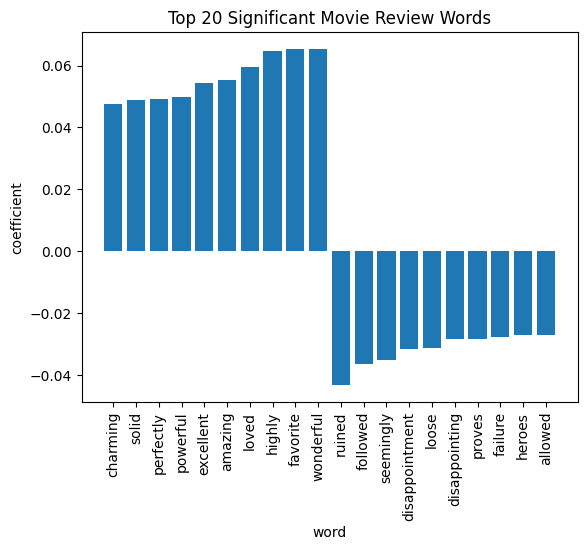

<Figure size 640x480 with 0 Axes>

In [11]:
negWords = pd.DataFrame(coeffs.head(10))

posWords = pd.DataFrame(coeffs.tail(10))

plot = pd.concat([posWords, negWords])


x = plot.iloc[:, 0]
y = plot.iloc[:,1]

plt.bar(x, y)


# setting y_label as price
plt.ylabel("coefficient")
plt.xticks(rotation=90)
plt.title("Top 20 Significant Movie Review Words")

# setting x-label as pen sold
plt.xlabel("word")

plt.show()

plt.savefig('FeatureImportance.png', bbox_inches="tight", dpi=300)



choose top 500 features

In [12]:
w = np.array(w)
w = pd.DataFrame(abs(w))

coeffs = labels.join(w,lsuffix='_left') #now we have each word associated with abs. coeff.
coeffs.columns = ['word','coeff']

coeffs = coeffs.sort_values(by=['coeff'], ascending = False)

# select top 500 features

featureSelection = coeffs.iloc[0:500,0].tolist()

xTrainClean = xTrain[xTrain.columns.intersection(featureSelection)] #pull only selected features from xTrain
xTestClean = xTest[xTest.columns.intersection(featureSelection)] # pull only selected features from xTest

trainInstances = trainInstances.drop(['review'], axis=1) #pull response variables and id
testInstances = testInstances.drop(['review'], axis=1)

imdbTrainingData = trainInstances.join(xTrainClean)
imdbTestingData = testInstances.join(xTestClean)

imdbTrainingData.to_csv("imdbTrainingData.csv")
imdbTestingData.to_csv("imdbTestingData.csv")


TASK 1.2 : NEWS GROUPS DATASET

load data

In [13]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics','alt.atheism','rec.sport.baseball','sci.med','talk.politics.misc']

twentyTrain = fetch_20newsgroups(subset='train',categories=categories, remove =['headers','footers','quotes'])
twentyTest = fetch_20newsgroups(subset='test',categories=categories,remove =['headers','footers','quotes'])

twentyTrain.target_names # check we got our categories



['alt.atheism',
 'comp.graphics',
 'rec.sport.baseball',
 'sci.med',
 'talk.politics.misc']

extract features from text files while removing common & rare words

In [14]:
vectorizer2 = CountVectorizer(stop_words='english',min_df=0.01)
twentyTrainCounts = vectorizer2.fit_transform(twentyTrain.data)
twentyTestCounts = vectorizer2.transform(twentyTest.data)

print(vectorizer2.vocabulary_) #view vocab


xTrainDFNews = pd.DataFrame(twentyTrainCounts.toarray())
xTrainDFNews.columns = vectorizer2.get_feature_names_out()
print(xTrainDFNews.info())


#test

xTestDFNews = pd.DataFrame(twentyTestCounts.toarray())
xTestDFNews.columns = vectorizer2.get_feature_names_out()
print(xTestDFNews.info())


{'time': 1080, 've': 1125, 'hear': 493, 'looking': 623, 'like': 604, 'past': 753, 'months': 685, 'sorry': 986, 'just': 566, 'month': 684, 'reality': 863, 'market': 649, 'manager': 645, 'graphics': 469, 'help': 499, 'little': 611, 'unfortunately': 1109, 'systems': 1048, 'used': 1115, 'create': 273, 'special': 994, 'effects': 362, 'man': 643, 'quality': 848, 'computer': 244, 'software': 981, 'written': 1179, 'animation': 87, 'took': 1084, 'hours': 517, 'high': 504, 'end': 365, 'processing': 827, 'level': 599, 'difficult': 320, 'impossible': 531, 'real': 862, '30': 31, 'second': 939, 'depends': 303, 'application': 95, 'true': 1096, 'requires': 897, 'complex': 243, '20': 19, '60': 42, 'similar': 967, 'training': 1090, 'rate': 856, 'low': 631, 'user': 1117, 'head': 490, 'data': 285, '15': 8, 'point': 789, 'new': 706, 'able': 50, 'run': 919, 'unix': 1112, 'general': 448, 'does': 334, 'support': 1036, 'usual': 1120, 'process': 826, 'management': 644, 'running': 920, 'sun': 1035, 'series': 949

arrange dataframe for feature selection

In [15]:
print(twentyTrain.target_names[twentyTrain.target[0]]) # prints category for first obs

print(twentyTrain.target[:10]) # .target gives us the index of the name in the target_names list

categories = twentyTrain.target_names

responseVarTrain = pd.DataFrame(twentyTrain.target)
responseVarTest = pd.DataFrame(twentyTest.target)

trainingSet = responseVarTrain.join(xTrainDFNews) # now training set has response and features

testingSet = responseVarTest.join(xTestDFNews) # now testing set has response and features

print(trainingSet.info())


comp.graphics
[1 1 0 2 1 3 0 4 3 4]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Columns: 1190 entries, 0 to young
dtypes: int64(1190)
memory usage: 24.7 MB
None


perform a PCA to observe how data cluster

In [16]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

trainingSet.columns = trainingSet.columns.astype(str)

model = PCA(n_components=100).fit(trainingSet)
PCs = model.transform(trainingSet) #fit PCA on training set
nPCs= model.components_.shape[0] #number of PCs

mostImportant = [np.abs(model.components_[i]).argmax() for i in range(nPCs)] #PCs explaning max variance

initialWords = vectorizer2.get_feature_names_out() #recall word for each component

mostImportantWords = [initialWords[mostImportant[i]] for i in range(nPCs)] # pull only most imporrant names

print("original number of features:",xTrainDFNews.shape[1])
print("new number of features:",PCs.shape[1]) #confirm we have reduced our dimensions

import plotly.express as px
from sklearn.decomposition import PCA

trainingSet['0'].replace({0: "alt.athesim", 1: "comp.graphics",2:"rec.sport.baseball",3:"sci.med",4:"talk.politics.misc"}, inplace=True) # recode response to numerical

fig = px.scatter_matrix(
    PCs,
    dimensions=range(4),
    color=trainingSet['0'])
fig.show()
plt.savefig('PCA.png', bbox_inches="tight", dpi=300)



original number of features: 1189
new number of features: 100


<Figure size 640x480 with 0 Axes>

Five Most Positive Features For Each Class

<ipython-input-17-48c52b44e528>:34: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-17-48c52b44e528>:34: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-17-48c52b44e528>:34: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-17-48c52b44e528>:34: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-17-48c52b44e528>:34: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



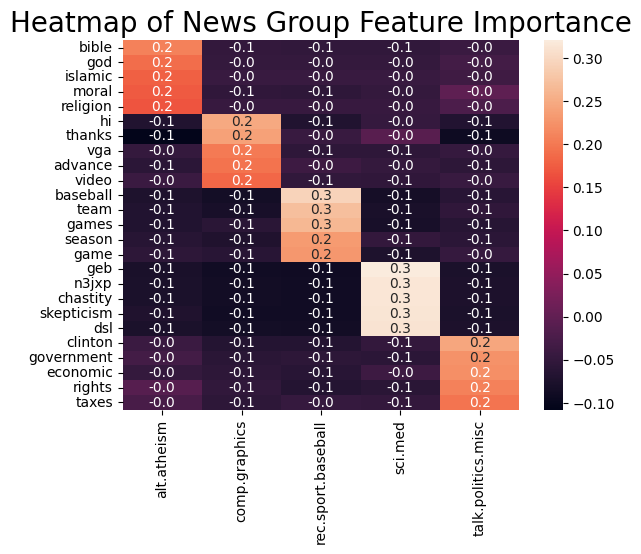

In [17]:
from sklearn.metrics import mutual_info_score

trainingSet = responseVarTrain.join(xTrainDFNews) # now training set has response and features

testingSet = responseVarTest.join(xTestDFNews) # now testing set has response and features

trainingSet.apply(pd.to_numeric)

labels = pd.DataFrame(vectorizer2.get_feature_names_out()) #need labels to identify features with top coefficient

TS1 = trainingSet.copy()
TS1[0].replace({0:1,1:0,2:0,3:0,4:0}, inplace=True)
TS2 = trainingSet.copy()
TS2[0].replace({0:0,1:1,2:0,3:0,4:0}, inplace=True)
TS3 = trainingSet.copy()
TS3[0].replace({0:0,1:0,2:1,3:0,4:0}, inplace=True)
TS4 = trainingSet.copy()
TS4[0].replace({0:0,1:0,2:0,3:1,4:0}, inplace=True)
TS5 = trainingSet.copy()
TS5[0].replace({0:0,1:0,2:0,3:0,4:1}, inplace=True)

categories = [TS1,TS2,TS3,TS4,TS5]

n = 1
labelImportance = pd.DataFrame()
for cat in range(0,5):
    DF = categories[cat]
    corr = DF.corr()
    responseCor = pd.DataFrame((corr[[0]]))
    responseCor.columns = ['corr']
    responseCor = responseCor.sort_values(by = ['corr'],ascending=False)
    select = responseCor.head(6)
    select = select.iloc[1:6,]
    labelImportance = labelImportance.append(select)
    n+=1

words = labelImportance.index.values.tolist()  # an ndarray method, you probably shouldn't depend on this

n = 1
corValues = list()
for cat in range(0,5):
    DF = categories[cat]
    corr = DF.corr()
    correlations = list()
    for item in range(len(words)):
      word = words[item]
      response = corr[0]
      value = response[word]
      correlations.append(value)
    correlations = pd.DataFrame(correlations)
    corValues.append(correlations)

words = np.array(words)

toMap = pd.DataFrame()
toMap.set_index = (words)
for values in range(len(corValues)):
  cat = corValues[values]
  cat.set_index(words)
  toMap[values] = cat

toMap.columns = ['alt.atheism',
 'comp.graphics',
 'rec.sport.baseball',
 'sci.med',
 'talk.politics.misc']

toMap = pd.DataFrame(toMap)
words = np.array(words)
toMap.set_index(words)
import seaborn as sns

y_axis_labels = words.tolist()
sns.heatmap(toMap,yticklabels=y_axis_labels,annot=True,fmt=".1f")
plt.title('Heatmap of News Group Feature Importance', fontsize = 20) # title with fontsize 20
plt.savefig('featureHeatmap.png', bbox_inches="tight", dpi=300)


Pull Important Features

In [18]:
trainingSet = responseVarTrain.join(xTrainDFNews) # now training set has response and features

testingSet = responseVarTest.join(xTestDFNews) # now testing set has response and features
#pull only the important features from original training vocabulary

xTrainDFNews_Important = xTrainDFNews[xTrainDFNews.columns.intersection(words)] #pull important feat. training

xTestDFNews_Important = xTestDFNews[xTestDFNews.columns.intersection(words)] #pull important feat. testing

trainingSet = responseVarTrain.join(xTrainDFNews_Important) # join response and feat

testingSet = responseVarTest.join(xTestDFNews_Important)


trainingSet.to_csv("trainingSetNewsGroups.csv")
testingSet.to_csv("testingSetNewsGroups.csv")


print(trainingSet.head())

   0  advance  baseball  bible  chastity  clinton  dsl  economic  game  games  geb  god  \
0  1        0         0      0         0        0    0         0     0      0    0    0   
1  1        0         0      0         0        0    0         0     0      0    0    0   
2  0        0         0      0         0        0    0         0     0      0    0    0   
3  2        0         0      0         0        0    0         0     0      0    0    0   
4  1        0         0      0         0        0    0         0     0      0    0    0   

   government  hi  islamic  moral  n3jxp  religion  rights  season  skepticism  taxes  team  \
0           0   0        0      0      0         0       0       0           0      0     0   
1           0   0        0      0      0         0       0       0           0      0     0   
2           0   0        0      0      0         0       0       0           0      0     0   
3           0   0        0      0      0         0       0       0       

In [19]:
#rows are observations (reviews). columns are: 'id', 'sentiment (0/1 neg/pos)', 'rating (1-10)', 'each of our 500 most important words' (col contains word count for each review)

imdbTraining = pd.read_csv("imdbTrainingData.csv")
imdbTraining.drop(imdbTraining.columns[0],axis=1,inplace=True)
imdbTesting = pd.read_csv("imdbTestingData.csv")
imdbTesting.drop(imdbTesting.columns[0],axis=1,inplace=True)

#rows are observations (news stories). columns are 'coded category 0-4', 'each of our 37 most important words'

newsGroupsTraining = pd.read_csv("trainingSetNewsGroups.csv")
newsGroupsTraining.drop(newsGroupsTraining.columns[0],axis=1,inplace=True)
newsGroupsTesting = pd.read_csv("testingSetNewsGroups.csv")
newsGroupsTesting.drop(newsGroupsTesting.columns[0],axis=1,inplace=True)

#categories = ['comp.graphics','alt.atheism','rec.sport.baseball','sci.med','talk.politics.misc'] referring to [0,1,2,3,4]



In [20]:
#francois - start of implementation ----



logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function



class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=5e-4, max_iters=1e4, verbose=False):
        self.add_bias = add_bias                      # false: a = xw,   true: a = xw + w_0
        self.learning_rate = learning_rate            # scalor of gradient descent.
        self.epsilon = epsilon                        # to get the tolerance for the norm of gradients:  Grad = 0 -> |grad| < eps.
        self.max_iters = max_iters                    # maximum number of iteration of gradient descent
        self.verbose = verbose                        # print result after fit or not
        self.cross_entropy_all_iteration = []         # for the second verify method. Defined here but not needed, for ease of finding.



    def cost_fn(self, x, y, w): # could make it into a static method, but who cares.
        N, D = x.shape
        z = np.dot(x, w)
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies
        return J

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
    """ Francois' notes:
    yh = y hat: y predicted
    X is a matrix since it has all points and each data point is multidimensional.
    This create a vector grad[d] = sum_n x_d^(n) ( yh ^(n) - y^(n))

    Uniform is the uniform distribution.  ( In collab )
     """


    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])  # [x1 x2 x3]^t -> [1 x1 x2 x3]^t : for every collum of the printed

        N,D = x.shape
        self.w = np.zeros(D)


        # the code snippet below is for gradient descent
        grad = np.inf
        t = 0
        self.cross_entropy_all_iteration = [] # If we fit twice, we shouldn't need to plot the thing twice
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            self.cross_entropy_all_iteration.append ( self.cost_fn(x,y,self.w) )
            grad = self.gradient(x, y)
            self.w = self.w - self.learning_rate * grad
            t += 1

        self.cross_entropy_all_iteration.append ( self.cost_fn(x,y,self.w) )

        if self.verbose:
            print(f'\n\n--------------------------\nterminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(grad)}')
            print(f'the weight found:\n {self.w}')

        return self

    def predict(self, x):
        """ x[N][feature number] -> y hat[N] | N: Number of points """
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def testOrValid( self, x, y):    # use for validation and testing.
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])  # [x1 x2 x3]^t -> [1 x1 x2 x3]^t : for every collum of the printed
        return self.cost_fn( x, y, self.w)

    def __str__(self):
        z = ""
        z += "add_bias: " + str(self.add_bias) + "\n"
        z += "learning rate: " + str(self.learning_rate) + "\n"
        z += "epsilon: " + str(self.epsilon) + "\n"
        z += "max iters: " + str(self.max_iters) + "\n"
        z+= "verbose: " + str(self.verbose) + "\n"
        z+= "----w-------: \n" + str(self.w) + "\n"
        return z

    def verify_epsilon(self, x, y ):  # perturbation method
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])  # [x1 x2 x3]^t -> [1 x1 x2 x3]^t : for every collum of the printed

        eps = self.w * 1e-5

        wp = self.w + eps
        wn = self.w - eps

        Jp = self.cost_fn(x,y, wp)
        Jn = self.cost_fn(x,y, wn)


        NumericGradient = ( Jp - Jn)/(2*eps)
        AnalyticGradient = self.gradient(x,y)

        diff = NumericGradient - AnalyticGradient
        plus = NumericGradient + AnalyticGradient
        verifyError = np.dot(diff,diff)/np.dot(plus,plus)


        if self.verbose:
            print("\nThe verification error by comparing analytical and numerical gradient is:", verifyError)

        return verifyError < 1e-8

    def verify_cross_entropy_all_itteration(self):
        plt.clf()
        plt.figure(figsize=((16/9)*3.6,3.6))
        plt.title("Cross Entropy (Loss) across all iterations")
        plt.ylabel("Cross entropy")
        plt.xlabel("iteration")
        plt.plot(self.cross_entropy_all_iteration)
        plt.show()
        plt.savefig('ce_iteration.png', bbox_inches="tight", dpi=300)

    # No plot countour.

    @staticmethod
    def validate_and_test(x_train, y_train, x_valid, y_valid, x_test, y_test):
        learning_rate_array = [ 0.1, 0.25, 0.6, 0.9]
        add_bias_array = [True, False]
        validation_cost_array = []
        modelArray = []

        bestModel = None
        bestModelCost = float('inf')


        for i, add_bias in enumerate(add_bias_array):
            validation_cost_array.append([])
            modelArray.append([])
            for j, learning_rate in enumerate(learning_rate_array):
                model = LogisticRegression(add_bias, learning_rate, verbose = True)
                model.fit(x_train, y_train)

                model.verify_epsilon( x_train, y_train )
                model.verify_cross_entropy_all_itteration()

                modelArray[i].append(model)
                modelCost = model.testOrValid(x_valid, y_valid)
                validation_cost_array[i].append( modelCost )     #Oof , the all iteration is gonna be big. 80kB per model... Afforfable.
                if modelCost < bestModelCost:
                    bestModel = model
                    bestModelCost = modelCost

        validation_cost_array = np.array(validation_cost_array)


        #################################################################
        testCost = bestModel.testOrValid(x_test, y_test)
        print("Here is the best model (the one tested on, best cross entropy)")
        print(bestModel)
        print("test Cost:",testCost)


        #################################################################
        color_array = ["red","blue"]
        plt.figure()
        plt.grid()
        plt.title("Cross entropy cost depending on models | Test CE = " + str(round(testCost,4)))
        plt.xlabel("learning rate")
        plt.ylabel("cross entropy")

        for i, add_bias in enumerate(add_bias_array):
            for j, learning_rate in enumerate(learning_rate_array):
                plt.plot(learning_rate, validation_cost_array[i,j], ".",color = color_array[i],
                         label = "add_bias: " + str(add_bias_array[i]) )

        plt.plot( bestModel.learning_rate, testCost, "*g", label = "test"   )
        plt.legend(bbox_to_anchor=(1.1, 1.1))
        plt.show()
        #################################################################

        print("BestValidCost, TestCost =", bestModelCost, testCost)
        return testCost, bestModelCost, bestModel, modelArray












In [21]:
# - Start of Analysis:

logistic_TrainAndValidate = pd.read_csv("imdbTrainingData.csv")
logistic_Test = pd.read_csv("imdbTestingData.csv")

logistic_TrainAndValidate = logistic_TrainAndValidate.drop( logistic_TrainAndValidate.columns[0], axis=1) # unnamed tag:
logistic_TrainAndValidate = logistic_TrainAndValidate.drop(['id'], axis=1)

logistic_Test = logistic_Test.drop( logistic_Test.columns[0], axis=1) # unnamed tag:
logistic_Test = logistic_Test.drop(['id'], axis=1)

logistic_TrainAndValidate_y = logistic_TrainAndValidate["sentiment"]
logistic_TrainAndValidate_x = logistic_TrainAndValidate.drop(['sentiment'],axis = 1)

logistic_Test_y = logistic_TrainAndValidate["sentiment"]
logistic_Test_x = logistic_TrainAndValidate.drop(['sentiment'],axis = 1)


In [ ]:
logistic_TrainAndValidate_y

0        1
1        1
2        1
3        1
4        1
        ..
12877    0
12878    0
12879    0
12880    0
12881    0
Name: sentiment, Length: 12882, dtype: int64

In [22]:
logistic_Train_x, logistic_Valid_x, logistic_Train_y, logistic_Valid_y = model_selection.train_test_split(
    logistic_TrainAndValidate_x, logistic_TrainAndValidate_y , test_size = 0.5, random_state=1, shuffle=True)


logistic_Train_x = np.array(logistic_Train_x )
logistic_Train_y = np.array(logistic_Train_y )

logistic_Valid_x = np.array(logistic_Valid_x )
logistic_Valid_y = np.array(logistic_Valid_y )

logistic_Test_x = np.array(logistic_Test_x )
logistic_Test_y = np.array(logistic_Test_y )


logistic_testCost, logistic_bestModelCost, logistic_bestModel, logistic_modelArray = LogisticRegression.validate_and_test(
    logistic_Train_x, logistic_Train_y,
    logistic_Valid_x, logistic_Valid_y,
    logistic_Test_x , logistic_Test_y )


TASK 3 : Experiments

 Prepare Data for Experiments on IMDB data:

In [24]:

imdbTraining = pd.read_csv("imdbTrainingData.csv")
imdbTraining= imdbTraining.sample(frac=1) #shuffle data

imdbTesting = pd.read_csv("imdbTestingData.csv")
imdbTesting= imdbTesting.sample(frac=1) #shuffle data


yTrain = imdbTraining['sentiment']
xTrain = imdbTraining.drop(["sentiment"],axis=1)
yTest = imdbTesting['sentiment']
xTest = imdbTesting.drop(['sentiment'],axis=1)




SKLearn Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

#Performance
performance = {}

DT = DecisionTreeClassifier()
DT = DT.fit(xTrain,yTrain)

#Predict the response for test dataset
predDT = DT.predict(xTest)
labelDT = yTest

aucDT = roc_auc_score(labelDT, predDT)
fprDT, tprDT, _ = roc_curve(labelDT, predDT) # We need a pos label change. Which is the
performance["DT"] = {'fpr':fprDT,'tpr':tprDT,'auc':aucDT}


Our Logistic Regression:

In [27]:
#logistic regression

LR = LogisticRegression(add_bias=True, learning_rate=.6, epsilon=1e-2, max_iters=1000, verbose=False) #params determined above
LR.fit(logistic_Train_x,logistic_Train_y)

predLR = LR.predict(logistic_Test_x)
labelLR = logistic_Test_y


fprLR, tprLR, _ = roc_curve(labelLR, predLR)
aucLR = roc_auc_score(labelLR, predLR)
performance["LR"] = {'fpr':fprLR,'tpr':tprLR,'auc':aucLR}



Plot top features

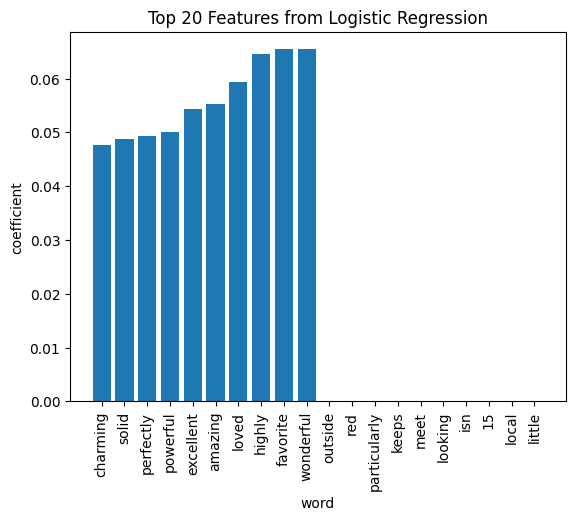

<Figure size 640x480 with 0 Axes>

In [28]:

w = pd.DataFrame(w)
labels = vectorizer.get_feature_names_out() #need labels to identify features with top coefficient
labels = pd.DataFrame(labels)

coeffs = labels.join(w, lsuffix = '_left')

coeffs.columns = ['word','coeff']

coeffs = coeffs.sort_values(by=['coeff']) #create one DF with feat names and coefficients. Sort.
coeffs = coeffs.dropna()


negWords = pd.DataFrame(coeffs.head(10))

posWords = pd.DataFrame(coeffs.tail(10))

plot = pd.concat([posWords, negWords])


x = plot.iloc[:, 0]
y = plot.iloc[:,1]

plt.bar(x, y)


# setting y_label as price
plt.ylabel("coefficient")
plt.xticks(rotation=90)
plt.title("Top 20 Features from Logistic Regression")

# setting x-label as pen sold
plt.xlabel("word")

plt.show()

plt.savefig('FeatureImportance.png', bbox_inches="tight", dpi=300)




Compare AUROC for Scikit-learn DT and our Logistic Regression

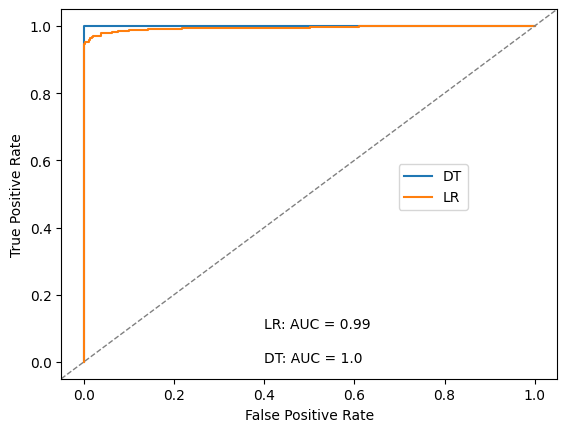

In [29]:

fig = plt.figure()

import matplotlib.pyplot as plt

i = 0
for model_name, model_perf in performance.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],
             label=model_name)
    plt.text(0.4, i, model_name + ': AUC = '+
             str(round(model_perf['auc'],2)))
    i += 0.1

plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('roc_cIMDB.png', bbox_inches='tight', dpi=300)



Compare Training Set Sizes

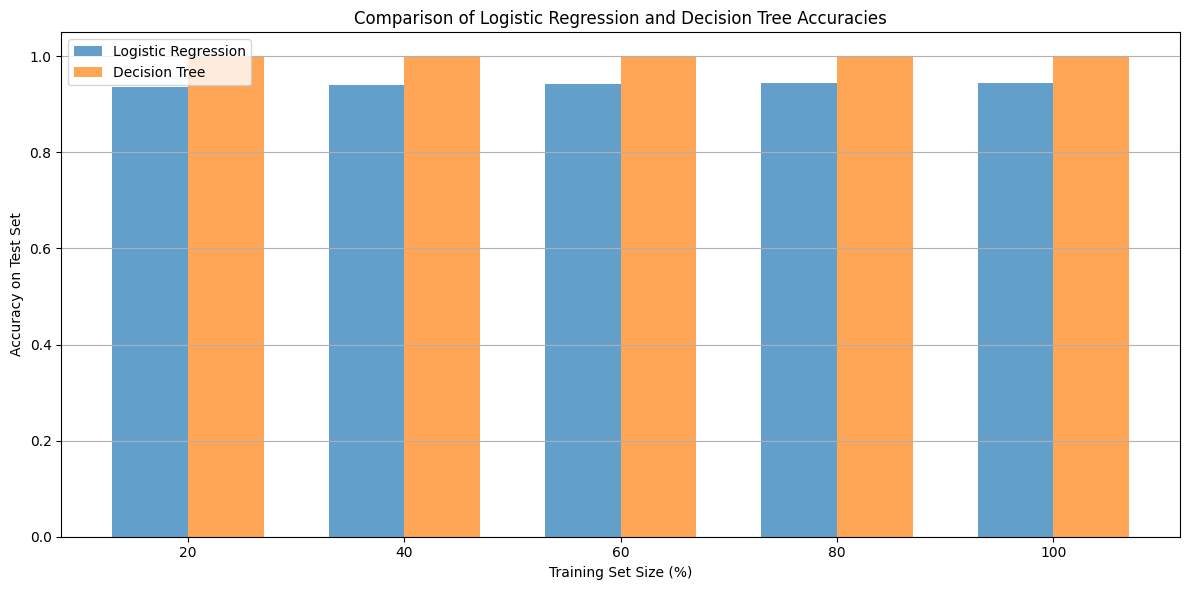

In [34]:
training_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
accuracies_logistic = []
accuracies_decision_tree = []

for size in training_sizes:
    if size < 1.0:
        # Create subset of training data
        X_train_subset, _, y_train_subset, _ = train_test_split(
            logistic_Train_x, logistic_Train_y, train_size=size, random_state=42)
    else:
        # Use the full training set
        X_train_subset = logistic_Train_x
        y_train_subset = logistic_Train_y

    # Train Logistic model
    y_pred = LR.predict(logistic_Test_x)
    accuracy_logistic = np.sum(y_pred == logistic_Test_y)logistic_Test_y.shape[0]
    accuracies_logistic.append(accuracy_logistic)

    # Train Decision Tree model
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(X_train_subset, y_train_subset)
    y_pred = decision_tree.predict(logistic_Test_x)
    accuracy_decision_tree = np.sum((y_pred==logistic_Test_y)/logistic_Test_y.shape[0])
    accuracies_decision_tree.append(accuracy_decision_tree)

# Convert training sizes to percentage for plotting
training_sizes_percent = [int(size * 100) for size in training_sizes]

# Define bar width for clarity
bar_width = 0.35

# Set positions of the bars
indices = np.arange(len(training_sizes_percent))
logistic_positions = indices - bar_width / 2
decision_tree_positions = indices + bar_width / 2

# Plotting the bar chart
plt.figure(figsize=(12, 6))


# Plot the bars for the Logistic Regression model
plt.bar(logistic_positions, accuracies_logistic, width=1, label='Logistic Regression', alpha=0.7)

# Plot the bars for the Decision Tree classifier
plt.bar(decision_tree_positions, accuracies_decision_tree, width=1, label='Decision Tree', alpha=0.7)

# Adding labels and title
plt.xlabel('Training Set Size (%)')
plt.ylabel('Accuracy on Test Set')
plt.title('Comparison of Logistic Regression and Decision Tree Accuracies')
plt.xticks(indices, training_sizes_percent)  # Set x-tick labels
plt.legend()
plt.tight_layout()
plt.grid(axis='y')

# Display the plot
plt.show()



In [ ]:
#----------------------- start of Ridwanur's code -----------------------#

Multiclass Regression implementation

In [35]:
class MulticlassRegression:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def one_hot_encode(self, y, nClasses):
        """Converts a vector of target labels to one-hot encoded format."""
        y_encoded = np.zeros((y.size, nClasses))
        y_encoded[np.arange(y.size), y.astype(int)] = 1
        return y_encoded

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def predict_classes(self, X):
        """Predicts class labels for each sample in X."""
        probabilities = self.predict(X)
        class_labels = np.argmax(probabilities, axis=1)
        return class_labels

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=1000):
        # One-hot encode y
        y_encoded = self.one_hot_encode(y, self.W.shape[1])

        # Initialize loss arrays
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)

        # Training loop
        for i in range(niter):
            self.W -= lr * self.grad(X, y_encoded)
            loss_train = self.ce(X, y_encoded)
            losses_train[i] = loss_train

            # Validation loss
            if X_valid is not None and y_valid is not None:
                y_valid_encoded = self.one_hot_encode(y_valid, self.W.shape[1])
                loss_valid = self.ce(X_valid, y_valid_encoded)
                losses_valid[i] = loss_valid
                print(f"iter {i}: Train Loss = {loss_train:.3f}, Validation Loss = {loss_valid:.3f}")
            else:
                print(f"iter {i}: Train Loss = {loss_train:.3f}")

        return losses_train, losses_valid

    def check_grad(self, X, y):
        # Ensure y is one-hot encoded
        if len(y.shape) == 1 or y.shape[1] == 1:
          y = self.one_hot_encode(y, self.W.shape[1])
          y = self.one_hot_encode(y, self.W.shape[1])

        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()



Multiclass Regression analysis


In [31]:
# Load datasets
multiclass_TrainAndValidate = pd.read_csv("trainingSetNewsGroups.csv")
multiclass_Test = pd.read_csv("testingSetNewsGroups.csv")  # Corrected to load the correct test dataset

# Drop the unnamed column
multiclass_TrainAndValidate = multiclass_TrainAndValidate.drop(multiclass_TrainAndValidate.columns[0], axis=1)
multiclass_Test = multiclass_Test.drop(multiclass_Test.columns[0], axis=1)

# Separate features and target variable
multiclass_TrainAndValidate_y = multiclass_TrainAndValidate["0"]
multiclass_TrainAndValidate_x = multiclass_TrainAndValidate.drop(['0'],axis = 1)
multiclass_Test_y = multiclass_Test["0"]
multiclass_Test_x = multiclass_Test.drop(['0'],axis = 1)

In [ ]:
multiclass_TrainAndValidate_y

0       1
1       1
2       0
3       2
4       1
       ..
2715    0
2716    4
2717    3
2718    3
2719    3
Name: 0, Length: 2720, dtype: int64

In [ ]:
# Split into training and validation sets
multiclass_Train_x, multiclass_Valid_x, multiclass_Train_y, multiclass_Valid_y = model_selection.train_test_split(
    multiclass_TrainAndValidate_x, multiclass_TrainAndValidate_y, test_size=0.5, random_state=1, shuffle=True)

# Convert to numpy arrays (might be optional depending on the implementation details)
multiclass_Train_x = np.array(multiclass_Train_x)
multiclass_Train_y = np.array(multiclass_Train_y)
multiclass_Valid_x = np.array(multiclass_Valid_x)
multiclass_Valid_y = np.array(multiclass_Valid_y)
multiclass_Test_x = np.array(multiclass_Test_x)
multiclass_Test_y = np.array(multiclass_Test_y)

# Initialize and train the model
nFeatures = multiclass_Train_x.shape[1]
nClasses = len(np.unique(multiclass_Train_y))
model = MulticlassRegression(nFeatures, nClasses)
losses_train, losses_valid = model.fit(multiclass_Train_x, multiclass_Train_y, multiclass_Valid_x, multiclass_Valid_y)

iter 0: Train Loss = 1965.352, Validation Loss = 1944.741
iter 1: Train Loss = 1872.443, Validation Loss = 1852.971
iter 2: Train Loss = 1820.104, Validation Loss = 1800.553
iter 3: Train Loss = 1785.308, Validation Loss = 1765.762
iter 4: Train Loss = 1760.020, Validation Loss = 1740.732
iter 5: Train Loss = 1740.557, Validation Loss = 1721.729
iter 6: Train Loss = 1724.963, Validation Loss = 1706.741
iter 7: Train Loss = 1712.094, Validation Loss = 1694.579
iter 8: Train Loss = 1701.233, Validation Loss = 1684.493
iter 9: Train Loss = 1691.907, Validation Loss = 1675.982
iter 10: Train Loss = 1683.785, Validation Loss = 1668.696
iter 11: Train Loss = 1676.630, Validation Loss = 1662.385
iter 12: Train Loss = 1670.267, Validation Loss = 1656.864
iter 13: Train Loss = 1664.562, Validation Loss = 1651.990
iter 14: Train Loss = 1659.412, Validation Loss = 1647.654
iter 15: Train Loss = 1654.732, Validation Loss = 1643.771
iter 16: Train Loss = 1650.458, Validation Loss = 1640.272
iter 17

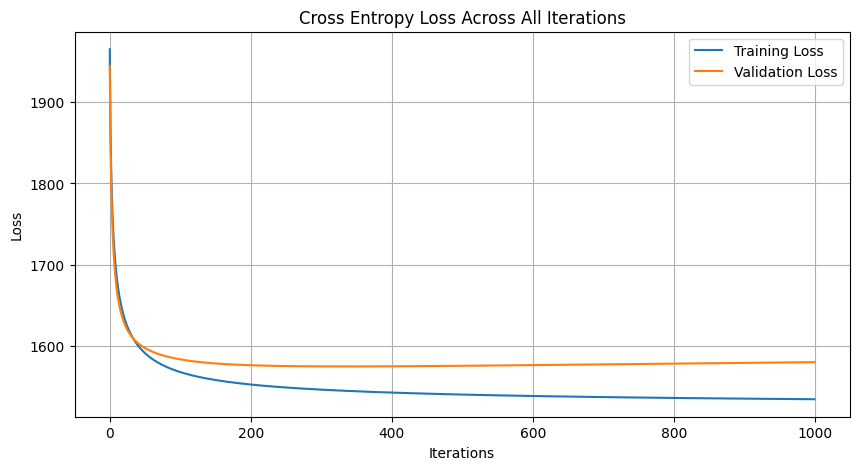

In [ ]:
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_valid, label='Validation Loss')
plt.title('Cross Entropy Loss Across All Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
multiclass_Train_y_encoded = np.zeros((multiclass_Train_y.size, nClasses))
multiclass_Train_y_encoded[np.arange(multiclass_Train_y.size), multiclass_Train_y.astype(int)] = 1

multiclass_Train_y_encoded.shape


# check grad
print(model.check_grad(multiclass_Train_x, multiclass_Train_y_encoded))

3.4852398970236823e-11


Calculate accuracy of model

In [ ]:
def evaluate(y, y_pred):
      accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
      accuracy = accuracy / y.shape[0]
      return accuracy

# Predict the probabilities for the validation set
y_pred_probs_valid = model.predict(multiclass_Valid_x)

# One-hot encode the true labels for the validation set
y_valid_encoded = model.one_hot_encode(multiclass_Valid_y, nClasses)

# Evaluate the model
validation_accuracy = evaluate(y_valid_encoded, y_pred_probs_valid)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

Validation Accuracy: 45.07%


Decision Tree model and accuracy

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=0)

# Fit the classifier to the training data
dt_classifier.fit(multiclass_Train_x, multiclass_Train_y)

# Predict class labels for the training and validation sets
y_pred_train_dt = dt_classifier.predict(multiclass_Train_x)
y_pred_valid_dt = dt_classifier.predict(multiclass_Valid_x)

# Calculate accuracy for training and validation sets
accuracy_train_dt = accuracy_score(multiclass_Train_y, y_pred_train_dt)
accuracy_valid_dt = accuracy_score(multiclass_Valid_y, y_pred_valid_dt)

print(f"Decision Tree Training Accuracy: {accuracy_train_dt * 100:.2f}%")
print(f"Decision Tree Validation Accuracy: {accuracy_valid_dt * 100:.2f}%")


Decision Tree Training Accuracy: 53.24%
Decision Tree Validation Accuracy: 50.15%


iter 0: Train Loss = 447.096
iter 1: Train Loss = 434.995
iter 2: Train Loss = 425.116
iter 3: Train Loss = 416.499
iter 4: Train Loss = 408.872
iter 5: Train Loss = 402.085
iter 6: Train Loss = 396.027
iter 7: Train Loss = 390.607
iter 8: Train Loss = 385.744
iter 9: Train Loss = 381.366
iter 10: Train Loss = 377.414
iter 11: Train Loss = 373.831
iter 12: Train Loss = 370.572
iter 13: Train Loss = 367.597
iter 14: Train Loss = 364.870
iter 15: Train Loss = 362.361
iter 16: Train Loss = 360.047
iter 17: Train Loss = 357.904
iter 18: Train Loss = 355.914
iter 19: Train Loss = 354.062
iter 20: Train Loss = 352.332
iter 21: Train Loss = 350.713
iter 22: Train Loss = 349.194
iter 23: Train Loss = 347.766
iter 24: Train Loss = 346.421
iter 25: Train Loss = 345.150
iter 26: Train Loss = 343.948
iter 27: Train Loss = 342.810
iter 28: Train Loss = 341.729
iter 29: Train Loss = 340.701
iter 30: Train Loss = 339.722
iter 31: Train Loss = 338.789
iter 32: Train Loss = 337.897
iter 33: Train Loss 

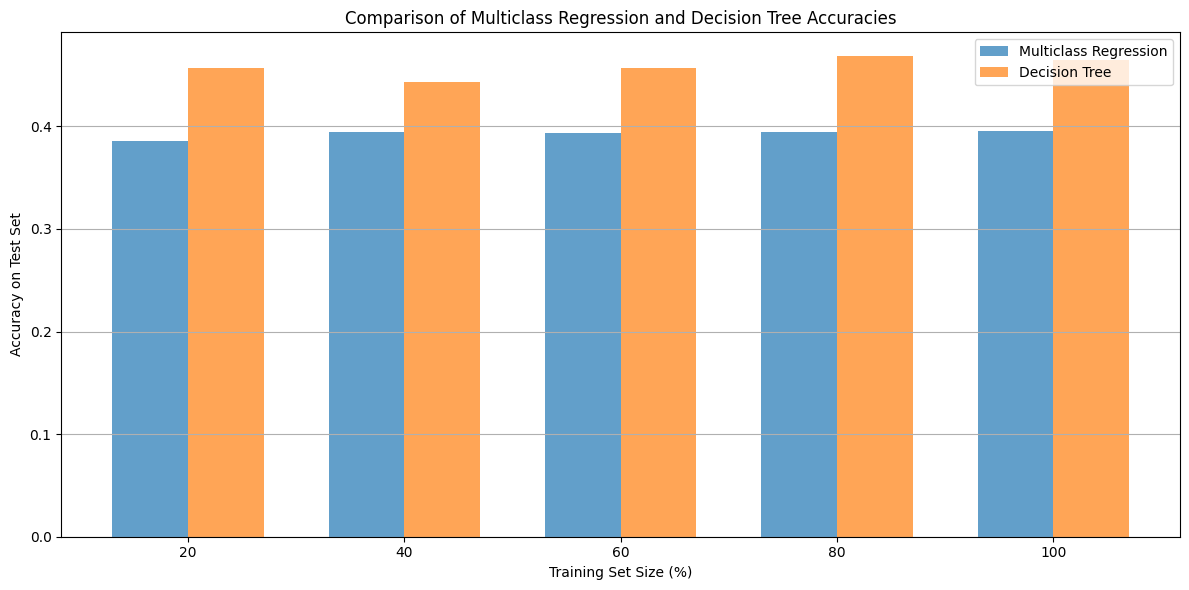

In [ ]:
training_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
accuracies_multiclass = []
accuracies_decision_tree = []

for size in training_sizes:
    if size < 1.0:
        # Create subset of training data
        X_train_subset, _, y_train_subset, _ = train_test_split(
            multiclass_Train_x, multiclass_Train_y, train_size=size, random_state=42)
    else:
        # Use the full training set
        X_train_subset = multiclass_Train_x
        y_train_subset = multiclass_Train_y

    # Train MulticlassRegression model
    model = MulticlassRegression(X_train_subset.shape[1], nClasses)
    model.fit(X_train_subset, y_train_subset)
    y_pred = model.predict_classes(multiclass_Test_x)
    accuracy_multiclass = accuracy_score(multiclass_Test_y, y_pred)
    accuracies_multiclass.append(accuracy_multiclass)

    # Train Decision Tree model
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(X_train_subset, y_train_subset)
    y_pred = decision_tree.predict(multiclass_Test_x)
    accuracy_decision_tree = accuracy_score(multiclass_Test_y, y_pred)
    accuracies_decision_tree.append(accuracy_decision_tree)

# Convert training sizes to percentage for plotting
training_sizes_percent = [int(size * 100) for size in training_sizes]

# Define bar width for clarity
bar_width = 0.35

# Set positions of the bars
indices = np.arange(len(training_sizes_percent))
multiclass_positions = indices - bar_width / 2
decision_tree_positions = indices + bar_width / 2

# Plotting the bar chart
plt.figure(figsize=(12, 6))

# Plot the bars for the MulticlassRegression model
plt.bar(multiclass_positions, accuracies_multiclass, width=bar_width, label='Multiclass Regression', alpha=0.7)

# Plot the bars for the Decision Tree classifier
plt.bar(decision_tree_positions, accuracies_decision_tree, width=bar_width, label='Decision Tree', alpha=0.7)

# Adding labels and title
plt.xlabel('Training Set Size (%)')
plt.ylabel('Accuracy on Test Set')
plt.title('Comparison of Multiclass Regression and Decision Tree Accuracies')
plt.xticks(indices, training_sizes_percent)  # Set x-tick labels
plt.legend()
plt.tight_layout()
plt.grid(axis='y')

# Display the plot
plt.show()
